# bigrams

> Implementation of bigram model using Pytorch

In [1]:
#| default_exp makemore.bigram

In [2]:
#| hide
from nbdev.showdoc import *

In [132]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [4]:
%matplotlib inline

## Read and Review Dataset

In [5]:
words = open("../data/names.txt", 'r').read().split(); words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
max(len(w) for w in words), min(len(w) for w in words), len(words)

(15, 2, 32033)

(array([6.500e+01, 5.750e+02, 2.983e+03, 7.133e+03, 9.657e+03, 6.819e+03,
        3.108e+03, 0.000e+00, 1.118e+03, 3.800e+02, 1.280e+02, 2.900e+01,
        3.000e+01, 6.000e+00, 2.000e+00]),
 array([ 2.        ,  2.86666667,  3.73333333,  4.6       ,  5.46666667,
         6.33333333,  7.2       ,  8.06666667,  8.93333333,  9.8       ,
        10.66666667, 11.53333333, 12.4       , 13.26666667, 14.13333333,
        15.        ]),
 <BarContainer object of 15 artists>)

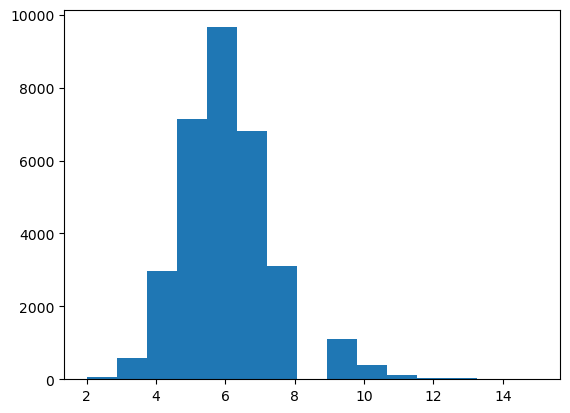

In [7]:
plt.hist([len(w) for w in words], bins=15)

Things to note :-

- We will do character level language model. A character level language model basically provides us with a prediction of next character given sequence of characters
- Even within a single word like `isabella` there is a lot of information in terms of statistical structure of characters in a word
  - `i` is the beginning characters
  - `s` follows `i`
  - `a` follows `is` or `isabell`
  - sequences of character like `isabella` terminates at `a`

- A bigram model is a weak language model in which we
  - Take 2 characters at a time 
  - Try to model / predict next character n given a known single character k
    - Prob(n|k)
    - In terms of intuition , given `r` what character are likely to follow `r`
    - We forget/ ignore the fact that we have a lot more information about the structure of characters from the word rather than just predicting next character based on previous character

## Bigram Frequency Map

In [8]:
bigrams = {}
for w in words:
    chrs = ['<S>']
    chrs.extend(w)
    chrs.append('<E>')
    for ch1, ch2 in zip(chrs, chrs[1:]):
        # print(ch1, ch2, w)
        bigrams[(ch1, ch2)] = bigrams.get((ch1, ch2),0) +1
sorted(bigrams.items(), key = lambda kv : -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [9]:
def stoi(words, start_str='<S>', end_str='<E>'):
    if start_str != end_str:
        d = {s:i for i,s in enumerate(sorted(list(set("".join(words)))))}
        n = len(d.values())
        d[start_str] = n
        d[end_str] = n+1
    else:
        d = {s:i+1 for i,s in enumerate(sorted(list(set("".join(words)))))}
        d[start_str] = 0
    return d

def itos(stoi):
    return { v:k for k, v in stoi.items()}

s2i = stoi(words)
i2s = itos(stoi(words))
s2i, i2s


({'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7,
  'i': 8,
  'j': 9,
  'k': 10,
  'l': 11,
  'm': 12,
  'n': 13,
  'o': 14,
  'p': 15,
  'q': 16,
  'r': 17,
  's': 18,
  't': 19,
  'u': 20,
  'v': 21,
  'w': 22,
  'x': 23,
  'y': 24,
  'z': 25,
  '<S>': 26,
  '<E>': 27},
 {0: 'a',
  1: 'b',
  2: 'c',
  3: 'd',
  4: 'e',
  5: 'f',
  6: 'g',
  7: 'h',
  8: 'i',
  9: 'j',
  10: 'k',
  11: 'l',
  12: 'm',
  13: 'n',
  14: 'o',
  15: 'p',
  16: 'q',
  17: 'r',
  18: 's',
  19: 't',
  20: 'u',
  21: 'v',
  22: 'w',
  23: 'x',
  24: 'y',
  25: 'z',
  26: '<S>',
  27: '<E>'})

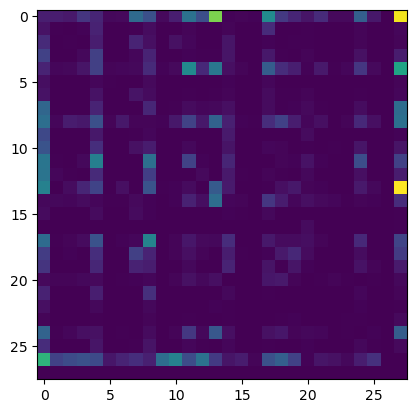

In [10]:
N = torch.zeros((28,28), dtype=torch.int32)
# bigrams = {}
for w in words:
    chrs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        # print(ch1, ch2, w)
        ix1 = s2i[ch1]
        ix2 = s2i[ch2]
        # bigrams[(ch1, ch2)] = bigrams.get((ch1, ch2),0) +1
        N[ix1, ix2] += 1
plt.imshow(N)

In [11]:
def get_bigram(s2i, words, start_str='<S>', end_str='<E>'):
    sz = len(s2i)
    N = torch.zeros((sz,sz), dtype=torch.int32)
    # bigrams = {}
    for w in words:
        chrs = [start_str] + list(w) + [end_str]
        for ch1, ch2 in zip(chrs, chrs[1:]):
            # print(ch1, ch2, w)
            ix1 = s2i[ch1]
            ix2 = s2i[ch2]
            # bigrams[(ch1, ch2)] = bigrams.get((ch1, ch2),0) +1
            N[ix1, ix2] += 1
    return N

get_bigram(s2i, words)

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

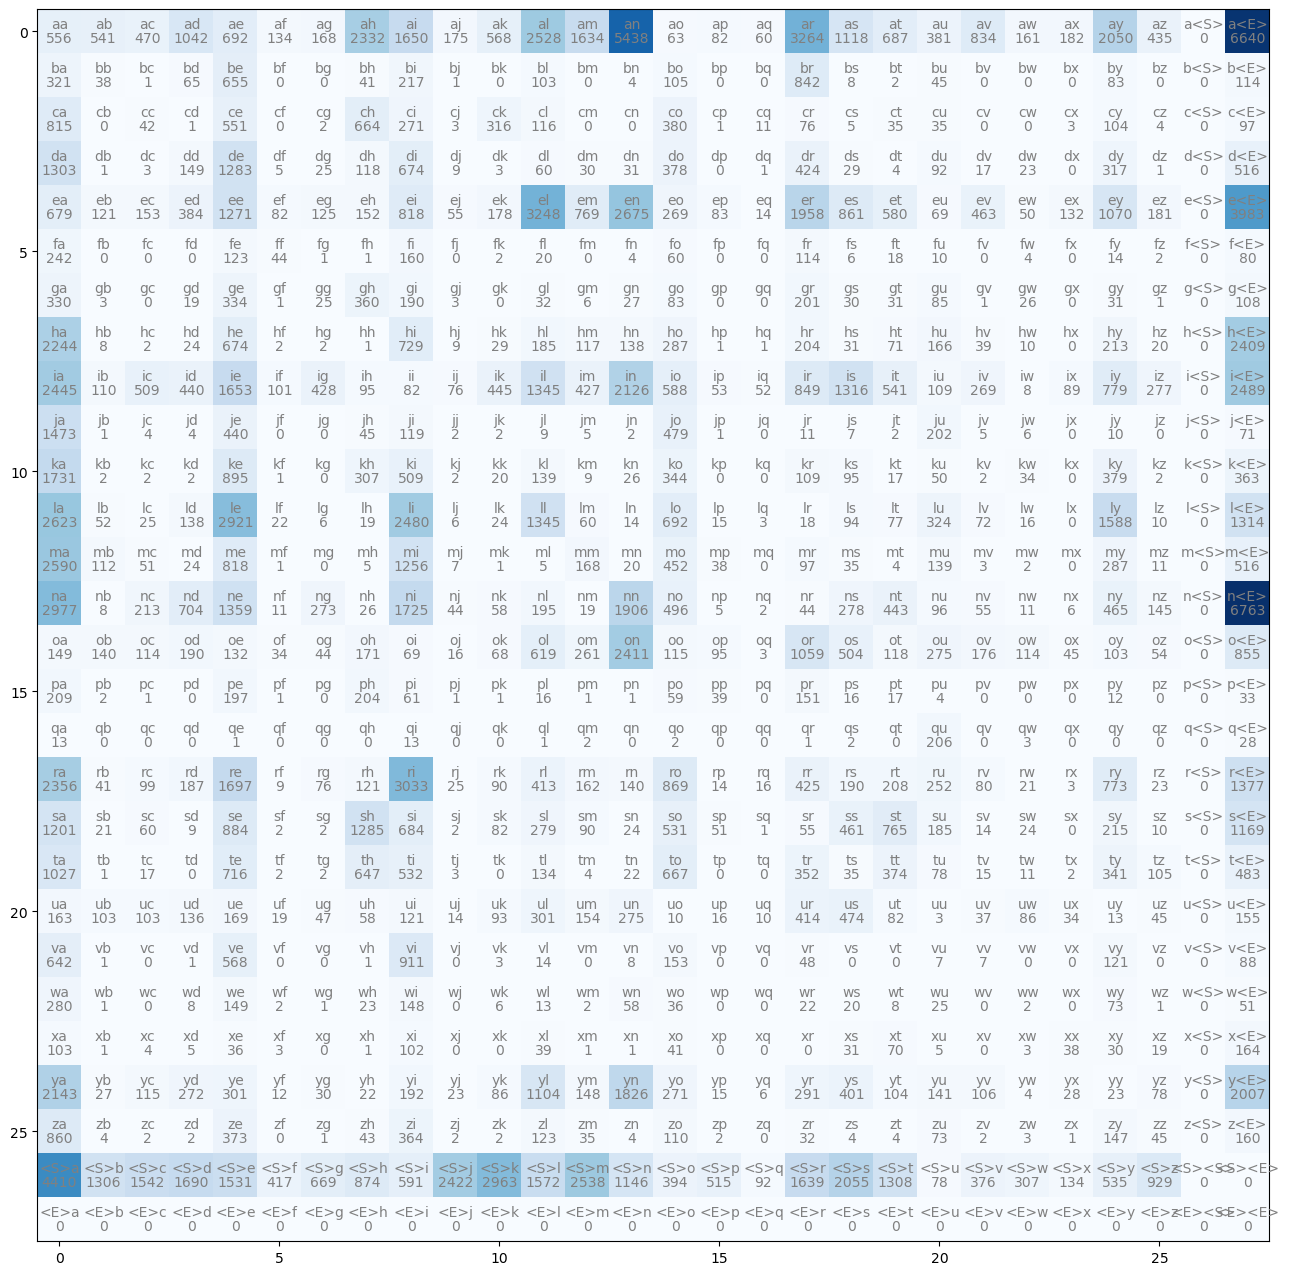

In [12]:
def draw_bigram(N, i2s):
    plt.figure(figsize=(16,16))
    plt.imshow(N, cmap='Blues')
    i_max, j_max = N.shape
    for i in range(i_max):
        for j in range(j_max):
            chstr = i2s[i]+i2s[j]
            plt.text(j,i, chstr, ha='center', va='bottom', color='gray')
            plt.text(j,i, N[i,j].item(), ha='center', va='top', color='gray')

draw_bigram(N, i2s)

- We are not being clever
    - `<E>` can't be first character -> entire row is zero
    - `<S>` can't be last character -> entire column is zero
    - We can only have `<S><E>` when we have an empty word

In [13]:
s2i = stoi(words, start_str='.', end_str='.')
i2s = itos(s2i)
s2i, i2s

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'})

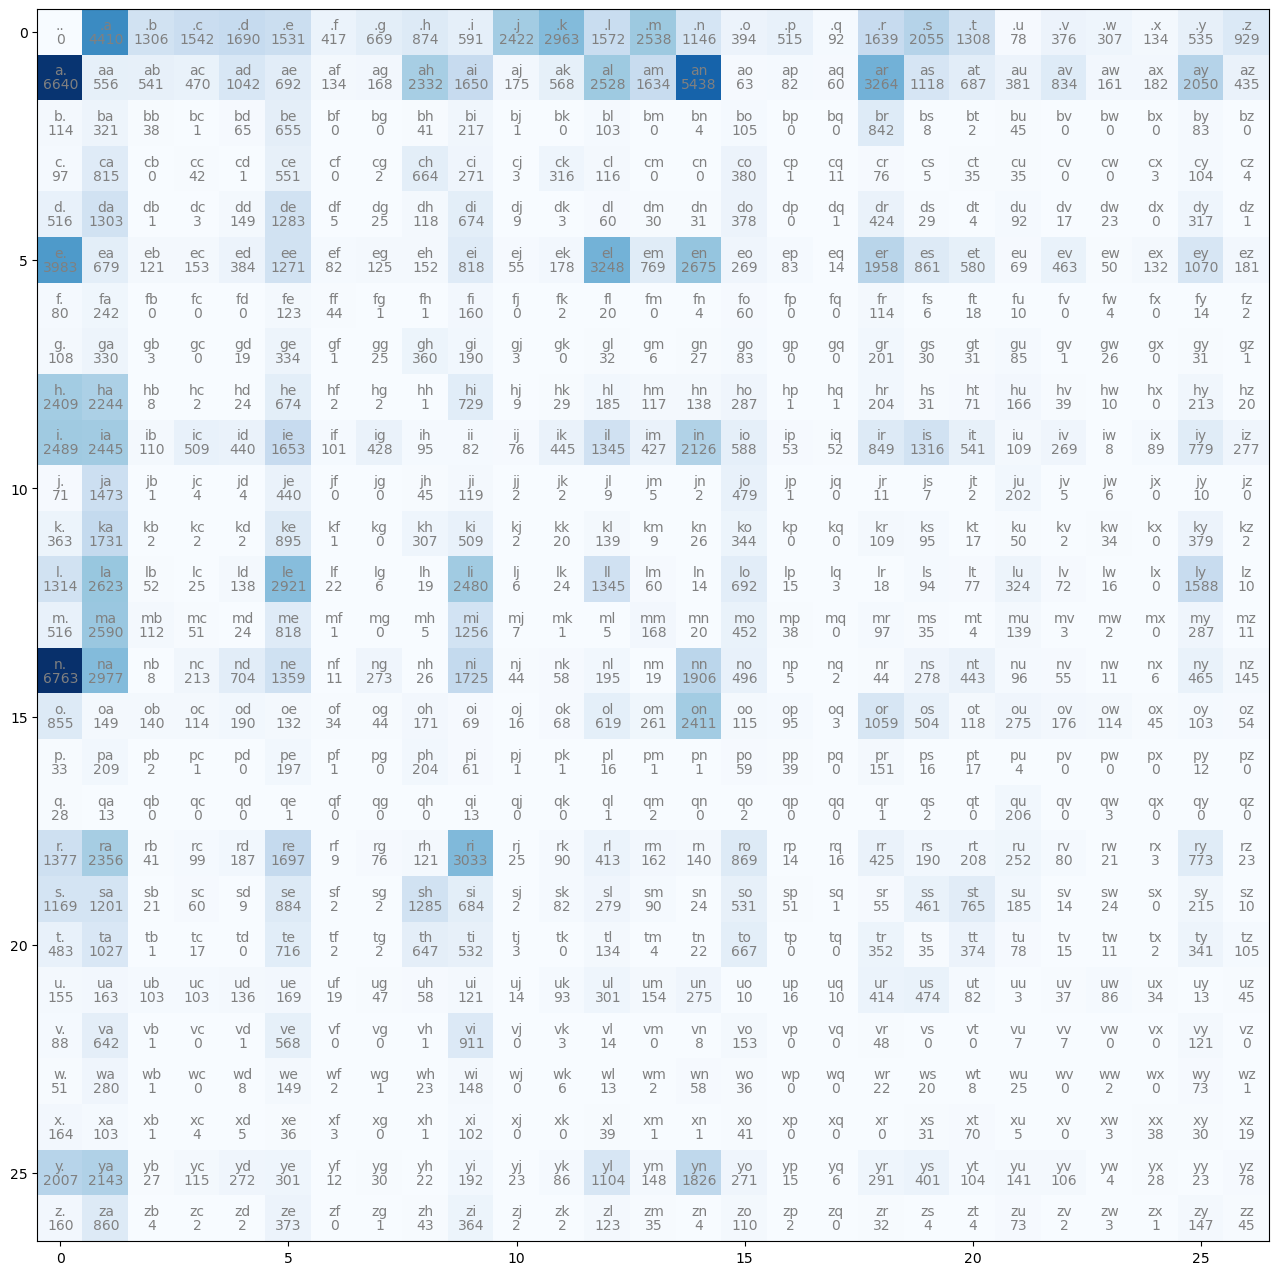

In [14]:
N = get_bigram(s2i, words, start_str='.', end_str='.')
draw_bigram(N, i2s)

We need to sample from above table which can all the information for our bigram model

## Sampling from the model

### Calculating Probabilities of starting word

In [15]:
p = N[0].float()
p /= p.sum()
#p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

So sampling from the above probability distribution (You give me probabilities and I will give u integers)

In [16]:
torch.multinomial??

Docstring:
multinomial(input, num_samples, replacement=False, *, generator=None, out=None) -> LongTensor

Returns a tensor where each row contains :attr:`num_samples` indices sampled
from the multinomial probability distribution located in the corresponding row
of tensor :attr:`input`.

.. note::
    The rows of :attr:`input` do not need to sum to one (in which case we use
    the values as weights), but must be non-negative, finite and have
    a non-zero sum.

Indices are ordered from left to right according to when each was sampled
(first samples are placed in first column).

If :attr:`input` is a vector, :attr:`out` is a vector of size :attr:`num_samples`.

If :attr:`input` is a matrix with `m` rows, :attr:`out` is an matrix of shape
:math:`(m \times \text{num\_samples})`.

If replacement is ``True``, samples are drawn with replacement.

If not, they are drawn without replacement, which means that when a
sample index is drawn for a row, it cannot be drawn again for that row.

.. no

In [17]:
# 
g = torch.Generator().manual_seed(2147483647)
# torch.multinomial(p, num_samples=3, replacement=True, generator=g)
t = torch.rand(3, generator=g)
t /= t.sum()
t


tensor([0.6064, 0.3033, 0.0903])

In [18]:
torch.multinomial(t, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [19]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
i2s[ix]

'c'

After sampling above character move to character that starts from that character

In [20]:
g = torch.Generator().manual_seed(2147483647)

def gen_word_uniform(i2s, n_samples=20, g=torch.Generator().manual_seed(2147483647)):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        while True:
            p = torch.ones(len(i2s))/len(i2s)
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            # print(i2s[ix])
            if ix == 0: break
            else:gen_word =  gen_word + i2s[ix]
        gen_words.append(gen_word)
    return gen_words


def gen_word_bigram(N, i2s, n_samples=20, g=torch.Generator().manual_seed(2147483647)):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        while True:
            p = N[ix].float()
            p /= p.sum()
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            # print(i2s[ix])
            if ix == 0: break
            else:gen_word =  gen_word + i2s[ix]
        gen_words.append(gen_word)
    return gen_words

gen_word_bigram(N, i2s, 20)

['cexze',
 'momasurailezitynn',
 'konimittain',
 'llayn',
 'ka',
 'da',
 'staiyaubrtthrigotai',
 'moliellavo',
 'ke',
 'teda',
 'ka',
 'emimmsade',
 'enkaviyny',
 'ftlspihinivenvorhlasu',
 'dsor',
 'br',
 'jol',
 'pen',
 'aisan',
 'ja']

In [21]:
gen_word_uniform(i2s, 20)


['cexzm',
 'zoglkurkicqzktyhwmvmzimjttainrlkfukzkktda',
 'sfcxvpubjtbhrmgotzx',
 'iczixqctvujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu',
 'dsdxxblnwglhpyiw',
 'igwnjwrpfdwipkwzkm',
 'desu',
 'firmt',
 'gbiksjbquabsvoth',
 'kuysxqevhcmrbxmcwyhrrjenvxmvpfkmwmghfvjzxobomysox',
 'gbptjapxweegpfwhccfyzfvksiiqmvwbhmiwqmdgzqsamjhgamcxwmmk',
 'iswcxfmbalcslhy',
 'fpycvasvz',
 'bqzazeunschck',
 'wnkojuoxyvtvfiwksddugnkul',
 'fuwfcgjz',
 'abl',
 'j',
 'nuuutstofgqzubbo',
 'rdubpknhmd']

In [22]:
def gen_word_prob(P, i2s, n_samples=20, g=torch.Generator().manual_seed(2147483647)):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        while True:
            p = P[ix]
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            # print(i2s[ix])
            if ix == 0: break
            else:gen_word =  gen_word + i2s[ix]
        gen_words.append(gen_word)
    return gen_words

In [23]:
M = torch.randint(3, 10, (2,2)); M
display(M)
M.sum(), M.sum(dim=0), M.sum(dim=1, keepdim=True)

tensor([[4, 8],
        [9, 9]])

(tensor(30),
 tensor([13, 17]),
 tensor([[12],
         [18]]))

In [24]:
M = torch.Tensor([[2,2],[3,3]])
M/M.sum(dim=1,keepdim=True)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [25]:
P_bigram = N/N.sum(dim=1, keepdim=True)
P_bigram
gen_word_prob(P_bigram, i2s)

['cexze',
 'momasurailezitynn',
 'konimittain',
 'llayn',
 'ka',
 'da',
 'staiyaubrtthrigotai',
 'moliellavo',
 'ke',
 'teda',
 'ka',
 'emimmsade',
 'enkaviyny',
 'ftlspihinivenvorhlasu',
 'dsor',
 'br',
 'jol',
 'pen',
 'aisan',
 'ja']

:::{.callout-important}

 - Respect the broadcasting rules described [here](https://pytorch.org/docs/stable/notes/broadcasting.html). Mistakes in broadcasting can lead to very hard to diagnose bugs
 - Figure out a quantifiable way to measure performance of our bigram model and quality of prediction generated from it.

:::

In [26]:
# correct
P_bigram = N/N.sum(dim=1, keepdim=True)
P_bigram
gen_word_prob(P_bigram, i2s)

['feniee',
 'zem',
 'deru',
 'firit',
 'gaikajahahbevare',
 'kiysthelenaririenah',
 'keen',
 'x',
 'al',
 'kal',
 'thavazeeromysos',
 'laitenimieegariseriyen',
 'k',
 'illeleldole',
 'meenisammigama',
 'mmin',
 'asharin',
 'alcalar',
 'jayn',
 'asaz']

In [27]:
#incorrect 

P_bigram = N/N.sum(dim=1) 
P_bigram
gen_word_prob(P_bigram, i2s)

# 27 27
# 27  -> 1 27 
## Leads to division by columns

['bezazexxzahay',
 'ppppppowyvivovockhougefulubuwycabo',
 'abdajonnuutetofaququbowrdubekahme',
 'phfacckaradazzzyj',
 'gh',
 'fryllbahrlrylmpph',
 'ron',
 'xxtayx',
 'vn',
 'gixxossth',
 'memppphlfftiriquvyudwhzynay',
 'kondrzevipubrbonovng',
 'ffkismjamchexxorizuwfexxtaququnnfwuquemawowssavajepporepawhoxsofikwesoynndavuxxwavurohansoxidezusckexxeghzulhaququwub',
 'kawuffumathuqubropphvigtaquh',
 'jux',
 'pppon',
 'zzzzagitwickycqionghvvilciqufuwh',
 'xiv',
 'qukemadedawifwwea',
 'fffffrlolelpppoyjelyngopphyazahimmyobdish']

In [28]:
# correct
P_bigram = N/N.sum(dim=1, keepdim=True)
P_bigram
gen_word_prob(P_bigram, i2s)

['con',
 'alomaruikeee',
 'djhammy',
 'arileedistanahistl',
 'on',
 'iy',
 'riyeti',
 'kazla',
 'aus',
 'ckadsi',
 'lisakhylendeese',
 'ferah',
 'ri',
 'alsorayna',
 'ahava',
 'eliladeladainalyav',
 'anava',
 'ke',
 'br',
 'jaylian']

### Measuring bigram performance

In [108]:
# ll = torch.tensor[0]
# ll = torch.tensor([0.0], dtype=float)
# for w in words[:3]:
#     for ch1, ch2 in zip(w, w[1:]):
#         ll += P_bigram[s2i[ch1], s2i[ch2]].log().item()
#         print(f"{ch1}{ch2}", P_bigram[s2i[ch1], s2i[ch2]].log().item())

def nll_score(P, words, s2i, start_str='.', end_str='.', average=False, verbose=False):
    ''' Quality of model and loss function'''
    ll = torch.tensor([0.0], dtype=float) # Log likelihood
    n = 0 
    for w in words:
        chrs = [start_str]+list(w)+ [end_str] # Don't forget start and end string in evaluating the model
        for ch1, ch2 in zip(chrs, chrs[1:]):
            ll += P[s2i[ch1], s2i[ch2]].log().item()
            n += 1
            if verbose: print(f"{ch1}{ch2}",f"prob: {P[s2i[ch1], s2i[ch2]]}", f"\tnll : {-P[s2i[ch1], s2i[ch2]].log().item()}")
    nll = -1*ll
    if average: nll /=n
    return nll

nll_score(P_bigram, words, s2i, average=True)

tensor([2.4540], dtype=torch.float64)

In [109]:
P_uniform = torch.ones([27, 27])/27 ## Completely random model - every bigram have same probability
P_uniform

nll_score(P_uniform, words, s2i)

tensor([751932.0112], dtype=torch.float64)

::: {callout-summary}

- For the best possible match every bigram will have prediction probability of 1
- Probability of entire dataset will be 1 (p1*p2*p3...pn)
- So log likelihood would be maximum at 0 .
- nll is minimum at 0 and maximum greater than zero. Forms a very nice loss function

Goal 

- Maximize likelihood of the data w.r.t model parameters (statistical modelling)
- Equivalent to maximizing log likelihood ( becoz log is monotonic)
- Equivalent to minimizing nll and average nll

:::

Text(0.5, 1.0, 'Negative Log function')

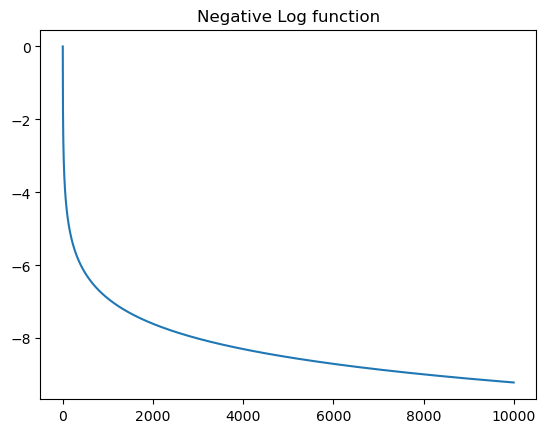

In [110]:
xs = torch.arange(1, 10000, 1)
ys = -xs.log()
plt.plot(xs, ys)
plt.title("Negative Log function")

In [111]:
1/len(s2i)**2

0.0013717421124828531

## Model Smoothing with fake count

In [112]:
nll_score(P_bigram, ['rahulx', 'andrejq'], s2i, average=True,verbose=True)

.r prob: 0.05116598680615425 	nll : 2.9726803302764893
ra prob: 0.18551181256771088 	nll : 1.6846367120742798
ah prob: 0.0688210129737854 	nll : 2.676246166229248
hu prob: 0.021796219050884247 	nll : 3.826018810272217
ul prob: 0.09601275622844696 	nll : 2.3432741165161133
lx prob: 0.0 	nll : inf
x. prob: 0.23529411852359772 	nll : 1.4469189643859863
.a prob: 0.13767053186893463 	nll : 1.9828919172286987
an prob: 0.16048398613929749 	nll : 1.8295611143112183
nd prob: 0.03841327130794525 	nll : 3.259352207183838
dr prob: 0.07714701443910599 	nll : 2.562042474746704
re prob: 0.13362205028533936 	nll : 2.012739896774292
ej prob: 0.0026930421590805054 	nll : 5.917083740234375
jq prob: 0.0 	nll : inf
q. prob: 0.10294117778539658 	nll : 2.273597478866577


tensor([inf], dtype=torch.float64)

In [123]:
sc = 1  #smoothing_coefficient -- laplace smoothing -> adding fake counts to everything
P = (N+sc)
P_bigram_smooth = P/P.sum(dim=1, keepdim=True); P_bigram_smooth
nll_score(P_bigram_smooth, ['rahulx', 'andrejq'], s2i, average=True,verbose=True)

.r prob: 0.051154084503650665 	nll : 2.9729130268096924
ra prob: 0.18519683182239532 	nll : 1.6863360404968262
ah prob: 0.06879570335149765 	nll : 2.6766140460968018
hu prob: 0.021850058808922768 	nll : 3.823551654815674
ul prob: 0.09550917148590088 	nll : 2.3485329151153564
lx prob: 7.150518649723381e-05 	nll : 9.545740127563477
x. prob: 0.22790054976940155 	nll : 1.4788459539413452
.a prob: 0.13758577406406403 	nll : 1.983507752418518
an prob: 0.16038569808006287 	nll : 1.8301737308502197
nd prob: 0.03841124475002289 	nll : 3.2594051361083984
dr prob: 0.07695093005895615 	nll : 2.564587354660034
re prob: 0.13341714441776276 	nll : 2.0142745971679688
ej prob: 0.002738386392593384 	nll : 5.900386333465576
jq prob: 0.0003416467516217381 	nll : 7.981733322143555
q. prob: 0.09698996692895889 	nll : 2.3331477642059326


tensor([3.4933], dtype=torch.float64)

- laplace smoothing -> adding fake counts to everything
- more you add more smoother model you have 
- less you add more peaky

## Bigram modelling using a Neural Network Framework

### Bigram Training Set

In [137]:
def get_bigram_data(s2i, words, start_str='.', end_str='.', verbose=False):
    # sz = len(s2i)
    # N = torch.zeros((sz,sz), dtype=torch.int32)
    # bigrams = {}
    xs, ys = [], []
    for w in words:
        chrs = [start_str] + list(w) + [end_str]
        for ch1, ch2 in zip(chrs, chrs[1:]):
            # print(ch1, ch2, w)
            ix1 = s2i[ch1]
            ix2 = s2i[ch2]
            xs.append(ix1)
            ys.append(ix2)
            if verbose: print(ch1, ch2)
    return torch.tensor(xs), torch.tensor(ys)

get_bigram_data(s2i, words[:1], verbose=True)

. e
e m
m m
m a
a .


(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

We want 

- When 0 is inputted we want 5 to have high probability
- 5 => 13 to have high probability
- 13 => 13 and 1 to have high probability
- 1 => 0 to have high probability

Caution 
- torch.Tensor -> Gives float tensor, stick with torch.tensor

:::callout-important

- It doesn't make sense to have neuron take an integer value
- We do one hot encoding to create vector per character
:::

In [192]:
xs, ys = get_bigram_data(s2i, words[:1], verbose=True)
xenc = F.one_hot(xs, num_classes=len(s2i)).float() # We need floats for neural nets
xenc, xenc.shape, len(s2i)

. e
e m
m m
m a
a .


(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([5, 27]),
 27)

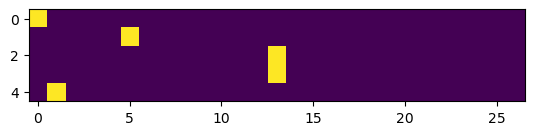

In [181]:
plt.imshow(xenc)

In [182]:
xenc.dtype

torch.float32

In [183]:
W = torch.randn((len(s2i), 1)) # (27,1)

out = xenc @ W # Feeding 5 examples generated from 1 word to a single neuron -- getting 5 outputs
xs.shape, xenc.shape, W.shape, out.shape

(torch.Size([5]), torch.Size([5, 27]), torch.Size([27, 1]), torch.Size([5, 1]))

Instead of a single neuron, we need 27 neuron.

In [185]:
W = torch.randn((len(s2i), len(s2i))) # (27,27)
xenc@W

tensor([[ 2.3269e+00, -8.6296e-01,  2.8525e-01, -1.1145e+00,  3.6785e-01,
          8.3824e-01, -6.5780e-01,  4.1087e-02, -6.8968e-02, -7.1986e-01,
         -4.4848e-01, -1.6098e-01, -8.8992e-01,  1.8326e-01, -2.4251e+00,
          1.7600e+00,  7.9750e-01, -1.3651e+00, -1.6792e+00, -3.1819e-01,
          1.9831e-04,  1.6386e+00,  3.4154e-01, -7.3995e-01, -3.5921e-01,
         -2.9955e+00,  1.2602e+00],
        [ 1.1364e+00,  1.5342e-02, -4.9327e-01,  1.2679e-01,  1.2797e+00,
         -1.1964e-01, -4.5364e-01, -1.4499e+00, -6.1507e-01,  1.0201e-01,
          1.3084e+00,  1.1515e+00,  5.7304e-02,  4.5202e-01,  2.1061e+00,
         -1.3398e+00,  1.0528e+00,  1.9249e-01, -4.9237e-01, -9.5744e-01,
         -1.5792e+00, -2.2935e-01, -1.5692e+00, -1.5299e+00,  6.7222e-01,
          6.2670e-01, -7.0042e-01],
        [-8.9724e-01,  5.7153e-01, -5.8725e-02, -1.8495e+00, -7.1260e-01,
         -2.0840e+00, -2.3288e-01, -1.5198e+00, -9.1831e-01,  5.6215e-01,
         -7.8519e-01,  1.4123e+00,  4.57

This tells us firing rate of neuron on input 

- 5,27 @ (27, 27) -> (5, 27)
- Output indicates for every one of those 27 neurons , what is the firing rate on every one of those 5 examples
- 27 some +ve , some -ve ; how to interpret them
- 27 neurons are giving us log counts -> to get we exponentiate them  elementwise

In [184]:
(xenc@W).exp()

tensor([[0.7886],
        [2.2577],
        [0.3552],
        [0.3552],
        [0.9731]])

In [204]:
# Forward pass
logits = xenc@W # log-counts
counts = logits.exp() # equivalent N
probs = counts/ counts.sum(1, keepdims=True); probs
loss = -probs.log().mean()
loss

tensor(3.7374)

In [189]:
probs[0], 
probs[0].shape, probs.shape

(torch.Size([27]), torch.Size([5, 27]))

In [ ]:
W = None

In [190]:
P_bigram_smooth.shape

torch.Size([27, 27])

In [200]:
# prob_13 = probs[3, 13]; prob_13
(xenc@W)[3, 13], (xenc[3]*W[:,13]).sum()

(tensor(0.5579), tensor(0.5579))

- `(xenc@W)[3, 13]`  indicates firing rate of the neuron(Firing rate of 13th neuron looking at the 3rd input)
- The way this is achieved by doing a dot product between 3rd input and 13th column of the weight matrix W
- Using matrix multiplication we can evaluate
  - Lot's of input example in a batch, and lot's of neuron with a weight in column 13

### Complete Neural Network setup

GOAL

- Produce probability prediction for next character in a sequence
- xenc@W produces a matrix of size 5, 27 full of positive and negative values
- What we want ?
  - These number to represent probabilities - probabilities have special structure => +ve , add to 1
  - These numbers can't be counts - counts are positive - these numbers are negative
  - We interpret output of these 27 numbers as log counts
  - To get counts we take log counts and exponentiate them 
  - Our output `probs` comes out as probabilities 
    - For every row they add to 1. ( every example in 5*27- 5 examples)
    - We interpret these numbers as Neural Network assignment of how likely is the next character

In [238]:
g = torch.Generator().manual_seed(2147483647)
lr = 10 # learning rate
W = torch.randn((len(s2i), len(s2i)), generator=g, requires_grad=True) #Initialize Weights
xs, ys = get_bigram_data(s2i, words[:1], verbose=True) #Get Data

## Forward pass
xenc = F.one_hot(xs, num_classes=len(s2i)).float() # We need floats for neural nets
logits = xenc@W # log-counts
counts = logits.exp() # equivalent N
probs = counts/ counts.sum(1, keepdims=True)
probs[torch.arange(len(xs)), ys].shape, probs.shape

## Calculate loss only for terms which are in the prediction - This can be imagined as Lookup of the prob corresponding to ys in form of table
loss = -probs[torch.arange(len(xs)), ys].log().mean()
print(loss, xenc.shape, probs.shape)

## Backward pass
W.grad = None
loss.backward()

# Parameter Update
W.data -=lr*W.grad

. e
e m
m m
m a
a .
tensor(3.7693, grad_fn=<NegBackward0>) torch.Size([5, 27]) torch.Size([5, 27])


In [262]:
def train(xs, ys, num_classes, epochs=100, lr =10, reg_coef=0.1, g = torch.Generator().manual_seed(2147483647)):
    W = torch.randn((num_classes, num_classes), generator=g, requires_grad=True) #Initialize Weights

    for i in range(epochs):
        xenc = F.one_hot(xs, num_classes=num_classes).float() # We need floats for neural nets
        logits = xenc@W # log-counts
        counts = logits.exp() # equivalent N
        probs = counts/ counts.sum(1, keepdims=True)
        # probs[torch.arange(len(xs)), ys].shape, probs.shape
        loss = -probs[torch.arange(len(xs)), ys].log().mean()+ (W**2).mean()*reg_coef
        print(i, loss)

        ## Backward pass
        W.grad = None
        loss.backward()

        # Parameter Update
        W.data -=lr*W.grad
        
    return W


xs, ys = get_bigram_data(s2i, words, verbose=False) #Get Data
num_classes = len(s2i)
W = train(xs, ys, num_classes, epochs=500)
    

0 tensor(3.8556, grad_fn=<AddBackward0>)
1 tensor(3.7616, grad_fn=<AddBackward0>)
2 tensor(3.6781, grad_fn=<AddBackward0>)
3 tensor(3.6032, grad_fn=<AddBackward0>)
4 tensor(3.5358, grad_fn=<AddBackward0>)
5 tensor(3.4751, grad_fn=<AddBackward0>)
6 tensor(3.4203, grad_fn=<AddBackward0>)
7 tensor(3.3708, grad_fn=<AddBackward0>)
8 tensor(3.3260, grad_fn=<AddBackward0>)
9 tensor(3.2855, grad_fn=<AddBackward0>)
10 tensor(3.2486, grad_fn=<AddBackward0>)
11 tensor(3.2150, grad_fn=<AddBackward0>)
12 tensor(3.1842, grad_fn=<AddBackward0>)
13 tensor(3.1559, grad_fn=<AddBackward0>)
14 tensor(3.1298, grad_fn=<AddBackward0>)
15 tensor(3.1056, grad_fn=<AddBackward0>)
16 tensor(3.0832, grad_fn=<AddBackward0>)
17 tensor(3.0623, grad_fn=<AddBackward0>)
18 tensor(3.0428, grad_fn=<AddBackward0>)
19 tensor(3.0246, grad_fn=<AddBackward0>)
20 tensor(3.0075, grad_fn=<AddBackward0>)
21 tensor(2.9915, grad_fn=<AddBackward0>)
22 tensor(2.9765, grad_fn=<AddBackward0>)
23 tensor(2.9624, grad_fn=<AddBackward0>)
24

In [263]:
gen_word_prob(P_bigram_smooth, i2s, n_samples=5)

['e', 'ra', 'tyiar', 'ratulalanay', 'ckhallylem']

In [264]:
def gen_word_nn(W, i2s, n_samples=20,    g=torch.Generator().manual_seed(2147483647)):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        while True:
            xenc = F.one_hot(torch.tensor([ix]), num_classes=len(i2s)).float() # We need floats for neural nets
            logits = xenc@W # log-counts
            counts = logits.exp() # equivalent N
            probs = counts/ counts.sum(1, keepdims=True)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            # print(i2s[ix])
            if ix == 0: break
            else:gen_word =  gen_word + i2s[ix]
        gen_words.append(gen_word)
    return gen_words

In [265]:
gen_word_nn(W, i2s, n_samples=5)

['cexze', 'momakurailezityha', 'konimittain', 'llayn', 'ka']

In [266]:
#| hide
import nbdev; nbdev.nbdev_export()
